In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSBBB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1368.2| 39.6372|-119.7094|       SNWD|USC00267691|    19|[C0 54 C0 54 C0 5...|2010.0|SSSBSBBB|
|   1392.3| 39.5114|-119.8454|       SNWD|US1NVWH0109|    32|[00 00 00 00 00 0...|2012.0|SSSBSBBB|
|   1932.4| 39.3128|-119.6483|       SNWD|USC00268761|     0|[F0 57 60 56 C0 5...|1953.0|SSSBSBBB|
|   1932.4| 39.3128|-119.6483|       SNWD|USC00268761|     5|[00 00 00 00 00 0...|1954.0|SSSBSBBB|
|   1932.4| 39.3128|-119.6483|       SNWD|USC00268761|     4|[F0 57 F0 57 C0 5...|1955.0|SSSBSBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

In [7]:
import pylab as plt
fig,axes=plt.subplots(1,1, figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes,label='Mean',title=m+' Mean')

In [40]:
import pylab as plt
fig,axes=plt.subplots(3,1, sharex='col', sharey='row',figsize=(15,10));
#fig.legend(loc='top right', bbox_to_anchor=(1, 0.5), fancybox=True)
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(1*EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
YearPlotter().plot(-1*EigVec,fig,axes[2],title=m+' Eigs Inverted',labels=['eig'+str(i+1) for i in range(k)])

In [9]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

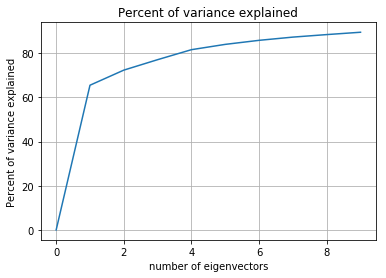

In [10]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [11]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [12]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1490
after filter 526


In [13]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [89]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=1, figsize=(15,5)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for j in range(column_n):
        row=rows[k]
        k+=1
        _title='%3.2f,r1=%3.2f'\
                %(row['coeff_4'],row['res_1'])
            #print i,j,_title,axes[i,j]
        plot_decomp(row,Mean,v,fig=fig,ax=axes[j],interactive=False,Title=_title)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [48]:
df3.show()

+-------------------+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|            coeff_4|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|               res_3|               res_4|          res_mean|    station|   total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
| -11749.30954282065|  3316.269866363725|  876.3998078981884|  595.4436102951687|   1774.9|SSSBSBBB| 39.3331| -120.173|  

In [45]:
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df4.take(12)
df4.select('coeff_2','res_2').show(4)

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
| -3954.403367922156|0.17009908383916988|
| -3669.622261344382|0.17700975976588362|
|-3500.5618978890143| 0.1839617336152635|
| -3420.081052317678|0.15713349488917877|
+-------------------+-------------------+
only showing top 4 rows



In [46]:
plot_recon_grid(rows)

In [55]:
df4=df3.sort(df3.coeff_1, ascending=False)
rows=df4.take(4)


In [81]:
plot_recon_grid(rows)#,column_n=4,row_n=1)

In [82]:
df4=df3.sort(df3.coeff_1, ascending=True)
rows=df4.take(4)
plot_recon_grid(rows)

In [84]:
df4=df3.sort(df3.coeff_2, ascending=False)
rows=df4.take(4)
plot_recon_grid(rows)

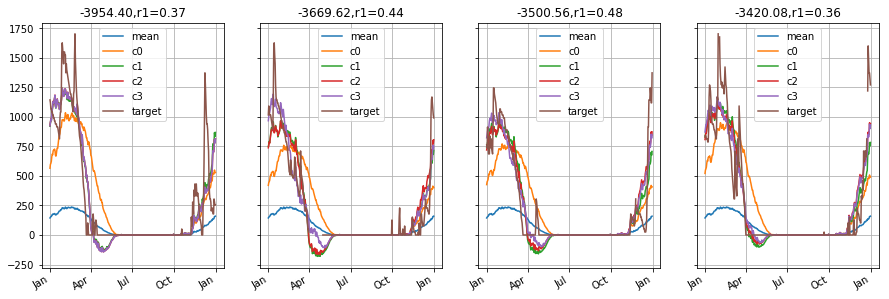

In [85]:
df4=df3.sort(df3.coeff_2, ascending=True)
rows=df4.take(4)
plot_recon_grid(rows)

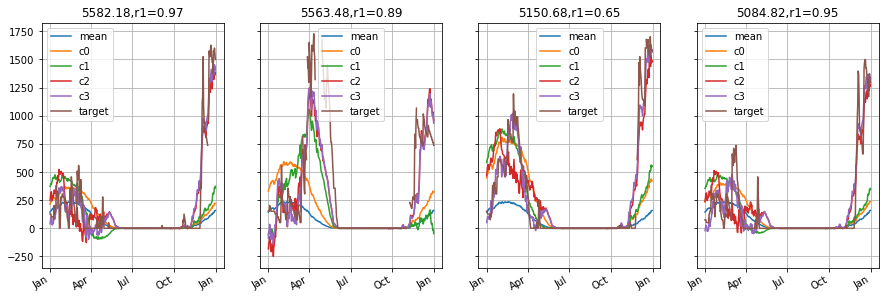

In [87]:
df4=df3.sort(df3.coeff_3, ascending=False)
rows=df4.take(4)
plot_recon_grid(rows)

In [88]:
df4=df3.sort(df3.coeff_3, ascending=True)
rows=df4.take(4)
plot_recon_grid(rows)

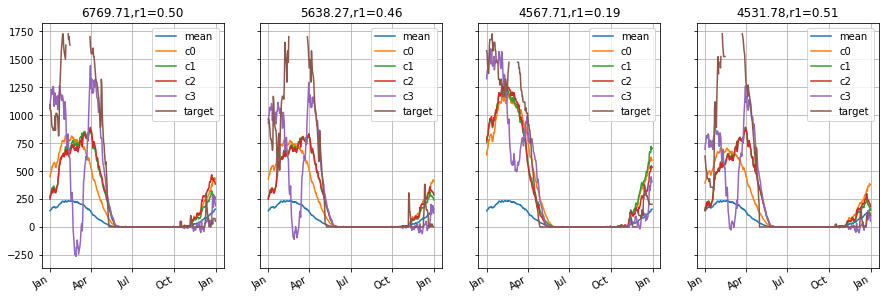

In [90]:
df4=df3.sort(df3.coeff_4, ascending=False)
rows=df4.take(4)
plot_recon_grid(rows)

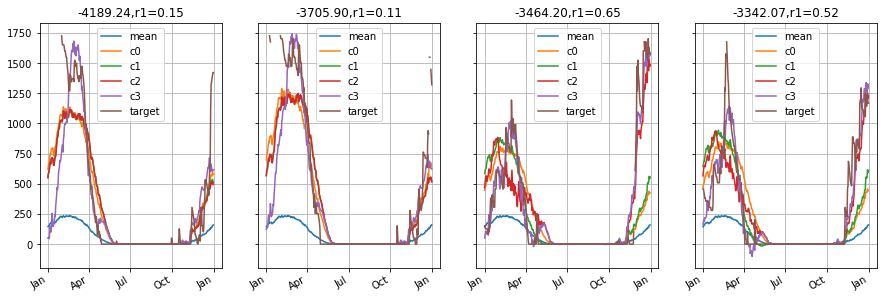

In [91]:
df4=df3.sort(df3.coeff_4, ascending=True)
rows=df4.take(4)
plot_recon_grid(rows)

In [18]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(12)
df5.select('coeff_2','res_2').show(4)

+-----------------+-------------------+
|          coeff_2|              res_2|
+-----------------+-------------------+
| 6425.42749912048|0.07565084619591933|
|6217.053155295609|0.24188342076265112|
|6110.993909671215|0.09864464967350835|
|5757.858905665091|0.15737285184742866|
+-----------------+-------------------+
only showing top 4 rows



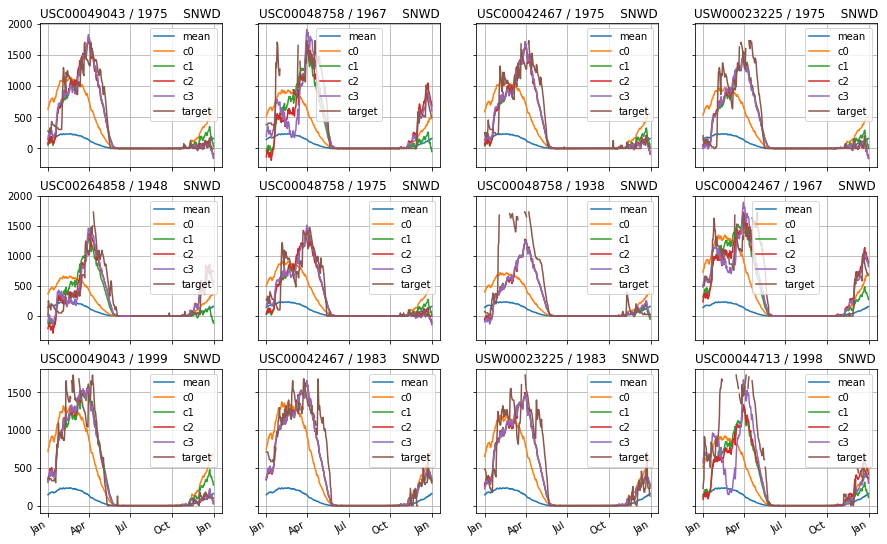

In [19]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [20]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

residual normalized norm  after mean: 0.767563830778
residual normalized norm  after mean + top eigs: [ 0.43486271  0.07565085  0.06796187  0.06310077]


### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [21]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))   
    #vals=vals[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

In [127]:
# A function for plotting the CDF of a given feature
colors1=['b','g','r','y']
def plot_CDF1():
    for i in range(1,5):
        feat='res_'+str(i)
        rows=df3.select(feat).sort(feat).collect()
        vals=[r[feat] for r in rows]
        P=np.arange(0,1,1./(len(vals)))   
    #vals=vals[vals[0]]+vals
        plot(vals,P,c=colors1[i-1],label=feat)
    legend()        
    title('cumulative distribution of residuals')
    ylabel('number of instances')
    grid()

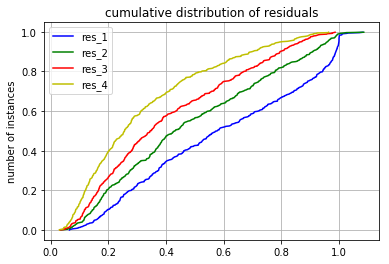

In [128]:
plot_CDF1()

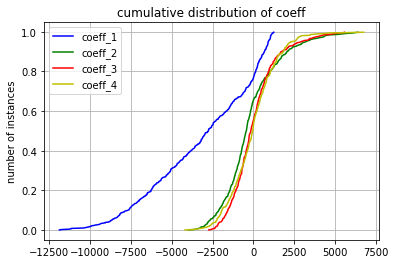

In [126]:
plot_CDF1()

In [92]:
plot_CDF('res_1')

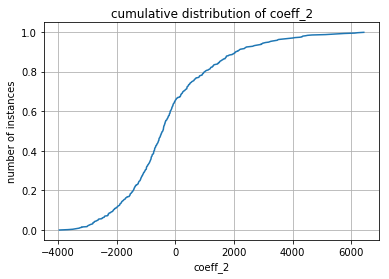

In [23]:
plot_CDF('coeff_2')

In [24]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [25]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.2M	../../Data/Weather/US_Weather_SSSBSBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SSSBSBBB_PRCP.parquet
2.3M	../../Data/Weather/decon_SSSBSBBB_SNOW.parquet
2.3M	../../Data/Weather/decon_SSSBSBBB_SNWD.parquet
3.9M	../../Data/Weather/decon_SSSBSBBB_TMAX.parquet
3.9M	../../Data/Weather/decon_SSSBSBBB_TMIN.parquet
3.1M	../../Data/Weather/decon_SSSBSBBB_TOBS.parquet


In [160]:
import matplotlib.pyplot as plt
%pylab inline
plt.plot(STAT['SNWD']['eigvec'][0],label='SNWD')
plt.plot(STAT['TOBS']['Mean'],label='TOBS')
#plt.plot(STAT['TOBS']['Mean']-STAT['SNWD']['Mean'],label='diff')
plt.legend()


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


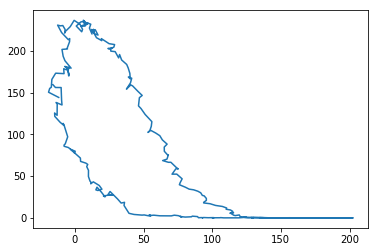

In [146]:
import matplotlib.pyplot as plt
%pylab inline
#plt.plot(STAT['SNWD']['Mean'],label='SNWD')
plt.plot(STAT['TOBS']['Mean'],STAT['SNWD']['Mean'])
#plt.plot(STAT['TOBS']['Mean']-STAT['SNWD']['Mean'],label='diff')
plt.legend()



In [147]:
import matplotlib.pyplot as plt
%pylab inline
#plt.plot(STAT['SNWD']['Mean'],label='SNWD')
plt.plot(STAT['TOBS']['Mean']/max(STAT['TOBS']['Mean']),STAT['SNWD']['Mean']/max(STAT['SNWD']['Mean']))
#plt.plot(STAT['TOBS']['Mean']-STAT['SNWD']['Mean'],label='diff')
plt.legend()

Populating the interactive namespace from numpy and matplotlib


In [154]:
x=[]
x.append(STAT['TOBS']['Mean'][:90])
x.append(STAT['TOBS']['Mean'][-90:])
y=[]
y.append(STAT['SNWD']['Mean'][:90])
y.append(STAT['SNWD']['Mean'][-90:])

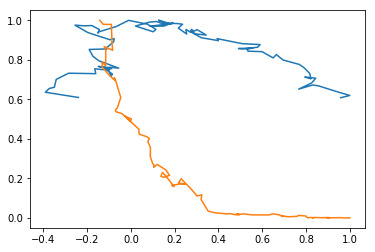

In [152]:
#plt.plot(STAT['SNWD']['Mean'],label='SNWD')
plt.plot(STAT['TOBS']['Mean'][:90]/max(STAT['TOBS']['Mean'][:90]),STAT['SNWD']['Mean'][:90]/max(STAT['SNWD']['Mean'][:90]))
plt.plot(STAT['TOBS']['Mean'][-90:]/max(STAT['TOBS']['Mean'][-90:]),STAT['SNWD']['Mean'][-90:]/max(STAT['SNWD']['Mean'][-90:]))
#plt.plot(STAT['TOBS']['Mean']-STAT['SNWD']['Mean'],label='diff')
plt.legend()


In [161]:
import matplotlib.pyplot as plt
%pylab inline
#plt.plot(STAT['SNWD']['Mean'],label='SNWD')
plt.plot(STAT['TMAX']['Mean'],STAT['SNWD']['eigvec'][0])
#plt.plot(STAT['TOBS']['Mean']-STAT['SNWD']['Mean'],label='diff')
plt.legend()

Populating the interactive namespace from numpy and matplotlib


In [157]:
STAT['SNWD']['eigvec'][0]

array([ -6.01647027e-02,  -8.96611379e-02,  -2.27567483e-02,
         1.20198693e-01,  -9.28110268e-03,  -1.55397244e-01,
         7.31271350e-03,  -9.61779285e-02,  -7.35447854e-03,
         1.18717098e-01,   3.09531722e-02,  -5.25020110e-02,
        -5.26661750e-02,   1.00726780e-01,  -3.78078031e-03,
         7.25309822e-03,   7.84886670e-02,  -2.37042361e-01,
        -1.74663444e-01,  -1.43499144e-02,  -1.42245971e-01,
        -2.45712473e-02,  -4.05622349e-02,   2.00110062e-01,
        -4.89435308e-02,   1.04850966e-01,   1.88291383e-01,
        -5.88478487e-02,   5.43926677e-02,  -6.07281605e-03,
         1.10357397e-01,   6.41887162e-02,   1.31818300e-01,
        -6.15932645e-02,   5.60930801e-02,  -9.28739982e-02,
        -2.84884626e-02,  -7.36554590e-02,   6.36285257e-02,
        -7.32991481e-03,   6.44032426e-02,  -4.63683105e-02,
        -1.46151633e-01,   1.16259671e-01,  -4.74640670e-02,
        -7.25373020e-02,   3.59408239e-02,  -5.99055636e-02,
        -9.94517260e-03,